<a href="https://colab.research.google.com/github/Mrwan-Atef/dino-neuromatch/blob/main/train_supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [ ]:
import torch
import torch.nn as nn
from torch import nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
import torch.distributed as dist # Maybe in the future we need multiple gpu's for training for now this is just a starting point
from torch import Tensor
from torchvision import transforms, datasets, models

from tqdm import tqdm

import numpy as np


import sys
import time
import math
from typing import List
import random
import os
import datetime
import subprocess
from collections import defaultdict, deque


from PIL import Image, ImageFilter, ImageOps

### Utils

In [ ]:
def _no_grad_trunc_normal_(tensor, mean, std, a, b):
    # Cut & paste from PyTorch official master until it's in a few official releases - RW
    # Method based on https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn("mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
                      "The distribution of values may be incorrect.",
                      stacklevel=2)

    with torch.no_grad():
        # Values are generated by using a truncated uniform distribution and
        # then using the inverse CDF for the normal distribution.
        # Get upper and lower cdf values
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)

        # Uniformly fill tensor with values from [l, u], then translate to
        # [2l-1, 2u-1].
        tensor.uniform_(2 * l - 1, 2 * u - 1)

        # Use inverse cdf transform for normal distribution to get truncated
        # standard normal
        tensor.erfinv_()

        # Transform to proper mean, std
        tensor.mul_(std * math.sqrt(2.))
        tensor.add_(mean)

        # Clamp to ensure it's in the proper range
        tensor.clamp_(min=a, max=b)
        return tensor


def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    # type: (Tensor, float, float, float, float) -> Tensor
    return _no_grad_trunc_normal_(tensor, mean, std, a, b)


class GaussianBlur(object):
    """
    Apply Gaussian Blur to the PIL image.
    """
    def __init__(self, p=0.5, radius_min=0.1, radius_max=2.):
        self.prob = p
        self.radius_min = radius_min
        self.radius_max = radius_max

    def __call__(self, img):
        do_it = random.random() <= self.prob
        if not do_it:
            return img

        return img.filter(
            ImageFilter.GaussianBlur(
                radius=random.uniform(self.radius_min, self.radius_max)
            )
        )


class Solarization(object):
    """
    Apply Solarisation to the PIL image.
    """
    def __init__(self, p):
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            return ImageOps.solarize(img)
        else:
            return img

### Seed

In [ ]:
def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness.
  NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


more or less the same as original one i didn't changed much just added couple of things here and there

### Arguments

In [ ]:
# see https://github.com/facebookresearch/dino/blob/main/main_dino.py get_args_parser() for explanations

class args_class:
  def __init__(self):
    # Model Parameters
    self.MOMENTUM_TEACHER = 0.996     #default 0.996
    self.OUT_DIM = 65536 #default 65536
    self.NORM_LAST_LAYER = True
    self.USE_BN_IN_HEAD = False     #default False

    # DINO LOSS Paramters
    self.CENTER_MOMENTUM = 0.9 # default 0.9

    # Temperature Student Parameters
    self.STUDENT_TEMP = 0.1 # default 0.1

    # Temperature Teacher Parameters
    self.WARMUP_TEACHER_TEMP = 0.04   #default 0.04
    self.TEACHER_TEMP = 0.04   #default 0.04
    self.WARMUP_TEACHER_TEMP_EPOCHS = 30 #default 30, but erroneously default 0 in the DINO paper?

    # Training / Optimizations Parameters
    self.USE_FP16 = True #default True
    self.WEIGHT_DECAY = 0.04 #default 0.04
    self.WEIGHT_DECAY_END = 0.4 # default 0.4
    self.CLIP_GRAD = 3.0 #default 3.0
    self.BATCH_SIZE_PER_GPU = 64 #default 64
    self.EPOCHS = 20 #default 100
    self.FREEZE_LAST_LAYER = 1 #default 1
    self.LR = 0.0005 #default 0.0005
    self.WARMUP_EPOCHS = 2 #default 10
    self.MIN_LR = 1e-6 #default 1e-6
    self.optimizer = 'adamw' # default adamw    TODO:Could be constructed here? not sure.
    self.DROP_PATH_RATE = 0.1 #default 0.1

    # Multi-Crop Parameters
    self.GLOBAL_CROPS_NUMBER = 2 #default 2
    self.GLOBAL_CROPS_SCALE = (0.1, 0.4) # default (0.4, 0.1)
    self.LOCAL_CROPS_NUMBER = 8 #default 8
    self.LOCAL_CROPS_SCALE = (0.05, 0.4) #default (0.05, 0.4)

    #Misc
    self.num_works = 10 # default 10
    self.output_dir = 'runs/'

    # Trackers
    self.best_f1 = 0.0
    # TODO: imgnet directory, how to store weights?

args = args_class()

### Architecture, DINOHead

In [ ]:
class DINOHead(nn.Module):
  def __init__(self, in_dim, out_dim, use_bn=False, norm_last_layer=True, nlayers=3, hidden_dim=2048, bottleneck_dim=256):
    super().__init__()
    nlayers = max(nlayers, 1)
    if nlayers == 1:
      self.mlp = nn.Linear(in_dim, bottleneck_dim)
    else:
      layers = [nn.Linear(in_dim, hidden_dim)]
      if use_bn:
        layers.append(nn.BatchNorm1d(hidden_dim))
      layers.append(nn.GELU())
      for _ in range(nlayers - 2):
        layers.append(nn.Linear(hidden_dim, hidden_dim))
        if use_bn:
          layers.append(nn.BatchNorm1d(hidden_dim))
        layers.append(nn.GELU())
      layers.append(nn.Linear(hidden_dim, bottleneck_dim))
      self.mlp = nn.Sequential(*layers)
    self.apply(self._init_weights)
    self.last_layer = nn.utils.weight_norm(nn.Linear(bottleneck_dim, out_dim, bias=False))
    self.last_layer.weight_g.data.fill_(1)
    if norm_last_layer:
      self.last_layer.weight_g.requires_grad = False

  def _init_weights(self, m):
    if isinstance(m, nn.Linear):
      trunc_normal_(m.weight, std=.02)
      if isinstance(m, nn.Linear) and m.bias is not None:
        nn.init.constant_(m.bias, 0)

  def forward(self, x):
    x = self.mlp(x)
    x = nn.functional.normalize(x, dim=-1, p=2)
    x = self.last_layer(x)
    return x

### ResNet18

In [ ]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )

def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class ResidualConvBlock(nn.Module):

    """
    Our copy of BasicBlock from torchvision.models.resnet

    """
    # To increease the final number of output channels
    expansion: int = 1

    def __init__(
        self,
        in_channels,
        out_channels:int,
        stride:int = 1,
        downsample = None,
        groups:int = 1,
        base_width:int = 64,
        dilation:int = 1,
        norm_layer = None

        ) -> None:
        super().__init__()

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        # Groups are != 1 when we use different filters for different channels of the image
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")

        # Dilation means adding "empty" pixels in the kernel, effectively making it bigger
        # Dilation == 1 means no dilation
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")

        # Note: names bn1, bn2 etc are kept even if norm_layer is not BatchNorm2d
        self.conv1 = conv3x3(in_channels, out_channels, stride) # conv3x3 is standard 3x3 conv
        self.bn1 = norm_layer(out_channels) # Normalise each feature map across spatial and batch dimension
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = norm_layer(out_channels)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):

        identity = x  # Store original input

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample is not None:
            identity = self.downsample(identity)

        x += identity

        x = self.relu(x)

        return x


class BottleneckConvBlock(nn.Module):

    """
    For resnet50 and above, insted of simply residual blocks, they used bottleneck blocks.

    They say it was more for computational efficiency than accuracy.


    In the original paper https://arxiv.org/abs/1512.03385 they used stride 1x1
    in the first layer of the bottleneck block.

    Apparently 3x3 is better and is what is implemented in torchvision.models.resnet

    """

    expansion: int = 4 # channels in the output is 4 times the number of channels in the input

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample = None,
        groups: int = 1, # Bottleneck blocks can have parallel convolutions with groups!=1 ( ResNeXt)
        base_width: int = 64, # How many channels in the internal 3x3 conv of each group
        dilation: int = 1,
        norm_layer = None
    ) -> None:
        super().__init__()

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        width = int(inplanes * (base_width / 64.0) ) * groups #(64 was the default val for base_width)

        self.conv1 = conv1x1(inplanes, width) # 1x1 conv to reduce the number of channels
        self.bn1 = norm_layer(width)

        self.conv2 = conv3x3(width, width, stride, groups, dilation) # the actual convolution in the block
        self.bn2 = norm_layer(width)

        self.conv3 = conv1x1(width, planes * self.expansion) # 1x1 conv to increase the number of channels
        self.bn3 = norm_layer(planes * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample # Downsample is used to match the number of channels in the input and output
        self.stride = stride


    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class OurResNet(nn.Module):
    """
    Our copy of ResNet from torchvision.models.resnet

    """

    def __init__(
        self,
        block, # block can be either ResidualConvBlock or Bottleneck class
        layers: List[int], # List of residual blocks in each layer, e.g. [2, 2, 2, 2] for ResNet18
        num_classes: int = 1000,
        zero_init_residual: bool = False, # not implemented Zero-initialize the last BN in each residual branch,
        groups: int = 1, # in Bottleneck
        width_per_group: int = 64, # in Bottleneck
        replace_stride_with_dilation: List[bool] = None, # in Bottleneck
        norm_layer = None
    ) -> None:
        super().__init__()

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1

        # Resnet has 4 layer gropus, only in the last 3 dilation can substitute stride
        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:

            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )

        self.groups = groups
        self.base_width = width_per_group

        # Reference for the following is Table 1 of ResNet paper https://arxiv.org/abs/1512.03385

        # First conv is 7x7 in avery resnet, stride 2, padding 3
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)

        # Maxpool is 3x3 with stride 2 and padding 1
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Initialize the layer groups
        # Numbers 64,128,256,512 get multiplyied by the expansion factor of the block (1 for ResidualConvBlock, 4 for BottleneckConvBlock)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # I just copied this zero_init_residual part

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, BottleneckConvBlock) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BottleneckConvBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    # With this, we can create any of the layer groups in square brackets(x2,x3,x6,x36 etc)
    # of Table 1 of the ResNet paper
    def _make_layer(
        self,
        block, # kind of block, can be either ResidualConvBlock or BottleneckConvBlock class
        planes: int,
        blocks: int, # number of blocks in the layer group
        stride: int = 1,
        dilate: bool = False, # if True, use dilation instead of stride
    ) -> nn.Sequential:

        norm_layer = self._norm_layer
        downsample = None

        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1

        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer))

        # We always have minimum 2 blocks in each layer group
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

def _resnet(
    block,
    layers: List[int],
    weights,
    progress: bool,
    **kwargs,
) -> OurResNet:

    if weights is not None:
        # _ovewrite_named_param(kwargs, "num_classes", len(weights.meta["categories"]))
        raise NotImplementedError("Weights upload not implemented yet")

    model = OurResNet(block, layers, **kwargs)

    return model

def ourResnet18( progress: bool = True, **kwargs ) -> OurResNet:
    """
    Constructs a ResNet-18 model.
    """
    return _resnet(
        ResidualConvBlock,
        [2, 2, 2, 2],
        weights=None,  # No weights for now
        progress=progress,
        **kwargs
    )

import torchvision

ourRes18 = ourResnet18(num_classes=10).to(DEVICE)
realRes18 = torchvision.models.resnet18(num_classes=10,weights=None).to(DEVICE)

print(f"weights are close? : {torch.allclose(ourRes18.conv1.weight, realRes18.conv1.weight)}")
print(f"If not, dont expect same logits")

# To have the same weights, they need to have the same exact initialization
ourRes18.load_state_dict(realRes18.state_dict())

print(f"weights are close? : {torch.allclose(ourRes18.conv1.weight, realRes18.conv1.weight)}")
print(f"If not, dont expect same logits")




weights are close? : False
If not, dont expect same logits
weights are close? : True
If not, dont expect same logits


### Utils

In [ ]:
def get_dino_schedules(args, n_iterations_per_epoch):
    """
    Creates the learning rate, weight decay, and teacher momentum schedules
    as pre-calculated NumPy arrays, matching the original DINO implementation.

    Args:
        args (args_class): An object containing training hyperparameters.
        n_iterations_per_epoch (int): The number of training steps in one epoch.

    Returns:
        tuple: A tuple containing:
            - lr_schedule (np.array): The learning rate for each iteration.
            - wd_schedule (np.array): The weight decay for each iteration.
            - momentum_schedule (np.array): The teacher momentum for each iteration.
    """
    # Total number of training iterations
    n_iterations = args.EPOCHS * n_iterations_per_epoch

    # Helper function to replicate the original DINO cosine scheduler
    def cosine_scheduler(base_value, final_value, total_iters, warmup_iters=0, start_warmup_value=0):
        warmup_schedule = np.array([])
        if warmup_iters > 0:
            warmup_schedule = np.linspace(start_warmup_value, base_value, warmup_iters)

        iters = np.arange(total_iters - warmup_iters)
        schedule = final_value + 0.5 * (base_value - final_value) * (1 + np.cos(np.pi * iters / len(iters)))

        schedule = np.concatenate((warmup_schedule, schedule))
        assert len(schedule) == total_iters
        return schedule

    # Linear scaling rule from the original paper: base_lr * batch_size / 256
    # Our code is single-GPU, so we use BATCH_SIZE_PER_GPU. For multi-GPU, this would be scaled by world_size.
    base_lr = args.LR * args.BATCH_SIZE_PER_GPU / 256.0

    lr_schedule = cosine_scheduler(
        base_value=base_lr,
        final_value=args.MIN_LR,
        total_iters=n_iterations,
        warmup_iters=args.WARMUP_EPOCHS * n_iterations_per_epoch,
        start_warmup_value=0, # Start warmup from 0
    )

    # No warmup for weight decay
    wd_schedule = cosine_scheduler(
        base_value=args.WEIGHT_DECAY,
        final_value=args.WEIGHT_DECAY_END,
        total_iters=n_iterations,
    )

    # No warmup for momentum
    momentum_schedule = cosine_scheduler(
        base_value=args.MOMENTUM_TEACHER,
        final_value=1.0,
        total_iters=n_iterations,
    )

    return lr_schedule, wd_schedule, momentum_schedule

### Loss, Train one Epoch, Augmentation


In [ ]:
class DINOLoss(nn.Module):
    """
    The loss function encourages a student network to match the output of a momentum teacher network.
    This is a form of self-distillation without labels.

    Args:
        args (args_class): An object containing the necessary hyperparameters.
    """
    def __init__(self, args):
        super().__init__()
        # The student temperature is constant
        self.student_temp = args.STUDENT_TEMP
        # The number of crops is the two global crops plus all local crops
        self.n_crops = args.GLOBAL_CROPS_NUMBER + args.LOCAL_CROPS_NUMBER
        self.center_momentum = args.CENTER_MOMENTUM
        self.register_buffer("center", torch.zeros(1, args.OUT_DIM)) # Initialize a non-trainable tensor and add to the module

        # The teacher temperature is scheduled to warm up from an initial value to a final value.
        # The DINO paper mentions a warmup from 0.04 to 0.07 over 30 epochs.
        teacher_schedule  = torch.linspace(
            args.WARMUP_TEACHER_TEMP,
            args.TEACHER_TEMP,
            args.EPOCHS,
        )
        self.register_buffer("teacher_temp_schedule", teacher_schedule)

    def forward(self, student_output, teacher_output, epoch):
        """
        Calculates the DINO loss.

        The student is trained to match the teacher's output. The teacher's output is centered
        and sharpened. The loss is computed as the cross-entropy between the teacher's and
        student's probability distributions over different views.

        Args:
            student_output (torch.Tensor): The output of the student network for all crops.
            teacher_output (torch.Tensor): The output of the teacher network for global crops.
            epoch (int): The current training epoch, used for the temperature schedule.

        Returns:
            torch.Tensor: The calculated DINO loss.
        """
        # student side
        student_out = student_output / self.student_temp
        student_out = student_out.chunk(self.n_crops)

        # teacher side: center & sharpen
        temp = self.teacher_temp_schedule[epoch]
        teacher_out = F.softmax((teacher_output - self.center) / temp, dim=-1)
        teacher_out = teacher_out.detach().chunk(2)

        total_loss, n_loss_terms = 0.0, 0
        for iq, q in enumerate(teacher_out):
            for v, sv in enumerate(student_out):
                if v == iq:
                    continue
                loss = torch.sum(-q * F.log_softmax(sv, dim=-1), dim=-1)
                total_loss += loss.mean()
                n_loss_terms += 1

        total_loss /= n_loss_terms
        self._update_center(teacher_output)
        return total_loss

    @torch.no_grad()
    def _update_center(self, teacher_output):
        """
        Update the center used for teacher output centering.
        This is a momentum update using the global batch statistics.

        This operation is performed in-place and without gradients.
        """
        # In DDP, teacher_output is the output for the local batch on the current process.
        # We need the mean of the outputs across all processes.
        batch_center = torch.mean(teacher_output, dim=0, keepdim=True)

        # synchronize across all processes
        if dist.is_initialized():
            dist.all_reduce(batch_center, op=dist.ReduceOp.SUM)
            batch_center /= dist.get_world_size()

        # momentum update
        self.center = self.center * self.center_momentum + batch_center * (1 - self.center_momentum)


In [ ]:
class CustomGaussianBlur(object):
    def __init__(self, strength=1.0):
        self.blur = GaussianBlur(p=1.0 if strength > 0.5 else 0.1)

    def __call__(self, img):
        return self.blur(img)


class CustomSolarisation(object):
    def __init__(self, p=0.2):
        self.solar = Solarization(p=p)

    def __call__(self, img):
        return self.solar(img)


class DataAugmentation(nn.Module):
    def __init__(self):
        super().__init__()
        flip_and_color_jitter = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply(
                [transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)],
                p=0.8
            ),
            transforms.RandomGrayscale(p=0.2),
        ])

        normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((160, 160)),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])


        # Global crop 2: weak blur, solarisation
        self.global_transfo2 = transforms.Compose([
            flip_and_color_jitter,
            CustomGaussianBlur(strength=0.1),
            CustomSolarisation(p=0.2),
            normalize,
        ])

    def __call__(self, image):
        return self.global_transfo2(image)

### MultiCropWrapper

In [ ]:
class MultiCropWrapper(nn.Module):
    """
    Perform forward pass separately on each resolution input.
    The inputs corresponding to a single resolution are clubbed and single
    forward is run on the same resolution inputs. Hence we do several
    forward passes = number of different resolutions used. We then
    concatenate all the output features and run the head forward on these
    concatenated features.
    """
    def __init__(self, backbone, head):
        super(MultiCropWrapper, self).__init__()
        # disable layers dedicated to ImageNet labels classification
        backbone.fc, backbone.head = nn.Identity(), nn.Identity()
        self.backbone = backbone
        self.head = head

    def forward(self, x):
        # convert to list
        if not isinstance(x, list):
            x = [x]
        #create a list of the ending indices for each group of crops of the same shape
        idx_crops = torch.cumsum(torch.unique_consecutive(
            torch.tensor([inp.shape[-1] for inp in x]),
            return_counts=True,
        )[1], 0)

        start_idx, output = 0, torch.empty(0).to(x[0].device)
        for end_idx in idx_crops:
            _out = self.backbone(torch.cat(x[start_idx: end_idx]))
            # The output is a tuple with XCiT model. See:
            # https://github.com/facebookresearch/xcit/blob/master/xcit.py#L404-L405
            if isinstance(_out, tuple):
                _out = _out[0]
            # accumulate outputs
            output = torch.cat((output, _out))
            start_idx = end_idx
        # Run the head forward on the concatenated features.
        return self.head(output)


### Train

In [ ]:
import torch
from tqdm import tqdm
from sklearn.metrics import f1_score

def train_one_epoch(student, criterion,
                    data_loader, val_data_loader,
                    optimizer, lr_schedule,
                    wd_schedule, momentum_schedule,
                    epoch, loss_scaler, args):
    """
    Trains the DINO model for one epoch and evaluates on the validation set.
    Saves the model when val_f1 > args.best_f1.

    Returns:
        float: avg training loss
        float: validation F1 score
    """
    # ---- Training ----
    student.train()
    train_loss = 0.0
    pbar = tqdm(data_loader, desc=f"Epoch {epoch} [Train]")
    for it, (images, labels) in enumerate(pbar):
        # update LR & WD
        for i, pg in enumerate(optimizer.param_groups):
            # pg["lr"] = lr_schedule[it]
            if i == 0:
                pg["weight_decay"] = wd_schedule[it]

        images = images.cuda(non_blocking=True)
        labels = labels.cuda(non_blocking=True)

        with torch.amp.autocast(device_type='cuda' ,enabled=args.USE_FP16, dtype=torch.bfloat16):
            outputs = student(images)
            loss = criterion(outputs, labels)

        if not torch.isfinite(loss):
            print(f"Non-finite loss {loss}; saving checkpoint and exiting.")
            torch.save({
                'epoch': epoch,
                'model_state_dict': student.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss.item(),
            }, 'model_checkpoint_infinite_loss.pth')
            import sys; sys.exit(1)

        optimizer.zero_grad(set_to_none=True)
        loss_scaler.scale(loss).backward()

        if args.CLIP_GRAD > 0:
            loss_scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(student.parameters(), args.CLIP_GRAD)

        loss_scaler.step(optimizer)
        lr_schedule.step()
        loss_scaler.update()

        torch.cuda.synchronize()
        train_loss += loss.item()
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(loss=f"{loss.item():.4f}", lr=f"{lr_schedule.get_last_lr()[-1]:.6f}")

    avg_train_loss = train_loss / len(data_loader)


    # ---- Validation & F1 Computation ----
    student.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for images, labels in tqdm(val_data_loader, desc=f"Epoch {epoch} [Val]"):
            images = images.cuda(non_blocking=True)
            labels = labels.cuda(non_blocking=True)

            with torch.amp.autocast(device_type='cuda' ,enabled=args.USE_FP16, dtype=torch.bfloat16):
                outputs = student(images)

            # assume classification: take highest‑logit class
            preds = outputs.argmax(dim=1)

            all_preds.append(preds.cpu())
            all_targets.append(labels.cpu())

    all_preds  = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()

    val_f1 = f1_score(all_targets, all_preds, average='macro')
    print(f"Epoch {epoch} validation F1 (macro): {val_f1:.4f}")

    # ---- Save Best Model ----
    if val_f1 > args.best_f1:
        args.best_f1 = val_f1
        torch.save({
            'epoch': epoch,
            'model_state_dict': student.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_f1': val_f1,
        }, 'best_model_2.pth')
        print(f"New best F1! Model saved to best_model_2.pth (F1={val_f1:.4f})")

    # return both metrics
    return avg_train_loss, val_f1


In [ ]:
def train(args):
    os.makedirs(args.output_dir, exist_ok=True)
    # 2. prep data (build dataset, dataloader)
    transform=DataAugmentation()

    dataset = datasets.Imagenette(
      root='/content/data',
      split='train',
      download=True,
      transform=transform
    )
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

    train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=args.BATCH_SIZE_PER_GPU,
        num_workers=args.num_works,
        pin_memory=True,
        drop_last=True,
    )
    val_data_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=args.BATCH_SIZE_PER_GPU,
        num_workers=args.num_works,
        pin_memory=True,
        drop_last=True,
    )

    student = models.resnet18(weights=None)
    in_features = student.fc.in_features
    student.load_state_dict(torch.load('best_model.pth', weights_only=False)['model_state_dict'], strict=False)
    student.fc = nn.Linear(in_features, 10)
    student = student.cuda()

    criterion = torch.nn.CrossEntropyLoss().cuda()

    optimizer = torch.optim.AdamW(student.parameters(), lr=args.LR, weight_decay=args.WEIGHT_DECAY)

    # 4. init schedulers
    #    This is where you would call the new function
    n_iter_per_epoch = len(train_data_loader)
    lr_schedule, wd_schedule, momentum_schedule = get_dino_schedules(args, n_iter_per_epoch)
    lr_schedule = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=args.LR, total_steps=args.EPOCHS * n_iter_per_epoch, anneal_strategy='cos', pct_start=0.1)
    # 5. init loss_scaler
    loss_scaler = torch.amp.GradScaler(device='cuda' ,enabled=args.USE_FP16)

    # 6. train loop
    for epoch in range(args.EPOCHS):
        # Train one epoch
        train_stats, f1_score = train_one_epoch(student, criterion, train_data_loader, val_data_loader,
                                      optimizer, lr_schedule, wd_schedule, momentum_schedule,
                                      epoch, loss_scaler, args)

        print(f"Epoch {epoch} training stats: {train_stats}, f1:{f1_score}")

        # Save checkpoints
        if epoch % 10 == 0 or epoch == args.EPOCHS - 1:
            torch.save({
                'epoch': epoch,
                'model_state_dict': student.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss_scaler_state_dict': loss_scaler.state_dict(),
                'args': args,
            }, f'{args.output_dir}/checkpoint_2_{epoch:04d}.pth')
            print(f"Checkpoint saved to {args.output_dir}/checkpoint_{epoch:04d}.pth")

    print("Training finished!")

In [ ]:
torch.cuda.empty_cache()

In [ ]:
train(args)

Epoch 0 [Val]: 100%|██████████| 29/29 [00:07<00:00,  3.68it/s]


Epoch 0 validation F1 (macro): 0.3711
New best F1! Model saved to best_model_2.pth (F1=0.3711)
Epoch 0 training stats: 1.3722628254001423, f1:0.37107841146261694
Checkpoint saved to runs//checkpoint_0000.pth


Epoch 1 [Val]: 100%|██████████| 29/29 [00:09<00:00,  3.22it/s]


Epoch 1 validation F1 (macro): 0.3144
Epoch 1 training stats: 1.4045173909704565, f1:0.31438198709710113


Epoch 2 [Val]: 100%|██████████| 29/29 [00:08<00:00,  3.25it/s]


Epoch 2 validation F1 (macro): 0.4045
New best F1! Model saved to best_model_2.pth (F1=0.4045)
Epoch 2 training stats: 1.2715365654331143, f1:0.4045476239929776


Epoch 3 [Val]: 100%|██████████| 29/29 [00:08<00:00,  3.48it/s]


Epoch 3 validation F1 (macro): 0.4745
New best F1! Model saved to best_model_2.pth (F1=0.4745)
Epoch 3 training stats: 1.100010227853969, f1:0.4745193354102735


Epoch 4 [Val]: 100%|██████████| 29/29 [00:08<00:00,  3.60it/s]


Epoch 4 validation F1 (macro): 0.5686
New best F1! Model saved to best_model_2.pth (F1=0.5686)
Epoch 4 training stats: 1.000694863877054, f1:0.5686429611125444


Epoch 5 [Val]: 100%|██████████| 29/29 [00:08<00:00,  3.49it/s]


Epoch 5 validation F1 (macro): 0.5972
New best F1! Model saved to best_model_2.pth (F1=0.5972)
Epoch 5 training stats: 0.911353098133863, f1:0.5972375676143813


Epoch 6 [Val]: 100%|██████████| 29/29 [00:08<00:00,  3.35it/s]


Epoch 6 validation F1 (macro): 0.6465
New best F1! Model saved to best_model_2.pth (F1=0.6465)
Epoch 6 training stats: 0.8144315375109851, f1:0.6465252272960991


Epoch 7 [Val]: 100%|██████████| 29/29 [00:09<00:00,  3.04it/s]


Epoch 7 validation F1 (macro): 0.6215
Epoch 7 training stats: 0.7314320898662179, f1:0.6214858739761778


Epoch 8 [Val]: 100%|██████████| 29/29 [00:08<00:00,  3.61it/s]


Epoch 8 validation F1 (macro): 0.6024
Epoch 8 training stats: 0.6418037136732522, f1:0.6024384410813929


Epoch 9 [Val]: 100%|██████████| 29/29 [00:08<00:00,  3.37it/s]


Epoch 9 validation F1 (macro): 0.6174
Epoch 9 training stats: 0.5799114784951938, f1:0.6173771283993582


Epoch 10 [Val]: 100%|██████████| 29/29 [00:08<00:00,  3.48it/s]


Epoch 10 validation F1 (macro): 0.7043
New best F1! Model saved to best_model_2.pth (F1=0.7043)
Epoch 10 training stats: 0.5020258584517544, f1:0.7043403680685685
Checkpoint saved to runs//checkpoint_0010.pth


Epoch 11 [Val]: 100%|██████████| 29/29 [00:08<00:00,  3.47it/s]


Epoch 11 validation F1 (macro): 0.7238
New best F1! Model saved to best_model_2.pth (F1=0.7238)
Epoch 11 training stats: 0.40169879768864586, f1:0.7238120169624229


Epoch 12 [Val]: 100%|██████████| 29/29 [00:08<00:00,  3.50it/s]


Epoch 12 validation F1 (macro): 0.7086
Epoch 12 training stats: 0.3485286935406216, f1:0.7085834891070882


Epoch 13 [Val]: 100%|██████████| 29/29 [00:08<00:00,  3.29it/s]


Epoch 13 validation F1 (macro): 0.7378
New best F1! Model saved to best_model_2.pth (F1=0.7378)
Epoch 13 training stats: 0.2761482037603855, f1:0.7377952764043417


Epoch 14 [Val]: 100%|██████████| 29/29 [00:08<00:00,  3.60it/s]


Epoch 14 validation F1 (macro): 0.7564
New best F1! Model saved to best_model_2.pth (F1=0.7564)
Epoch 14 training stats: 0.21059315531688222, f1:0.7563590414994744


Epoch 15 [Val]: 100%|██████████| 29/29 [00:08<00:00,  3.59it/s]


Epoch 15 validation F1 (macro): 0.7672
New best F1! Model saved to best_model_2.pth (F1=0.7672)
Epoch 15 training stats: 0.1623583447061858, f1:0.7672241034763079


Epoch 16 [Val]: 100%|██████████| 29/29 [00:07<00:00,  3.72it/s]


Epoch 16 validation F1 (macro): 0.7667
Epoch 16 training stats: 0.13619375506700096, f1:0.7666889483754804


Epoch 17 [Val]: 100%|██████████| 29/29 [00:08<00:00,  3.23it/s]


Epoch 17 validation F1 (macro): 0.7590
Epoch 17 training stats: 0.1197348752737803, f1:0.7590134031374479


Epoch 18 [Val]: 100%|██████████| 29/29 [00:08<00:00,  3.32it/s]


Epoch 18 validation F1 (macro): 0.7688
New best F1! Model saved to best_model_2.pth (F1=0.7688)
Epoch 18 training stats: 0.09684524386805499, f1:0.7687541630093474


Epoch 19 [Val]: 100%|██████████| 29/29 [00:08<00:00,  3.32it/s]


Epoch 19 validation F1 (macro): 0.7612
Epoch 19 training stats: 0.09858944617464381, f1:0.7611696690859212
Checkpoint saved to runs//checkpoint_0019.pth
Training finished!


Accuracy:  0.8140
Precision: 0.8132
Recall:    0.8140
F1 Score:  0.8129
Weighted‑OvR AUC: 0.9770


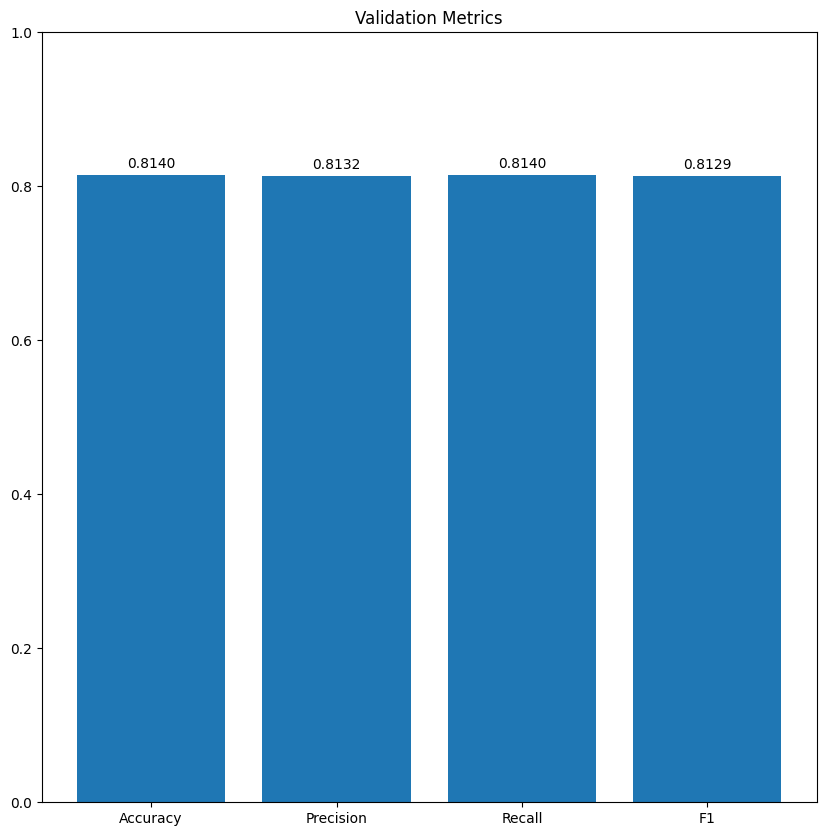

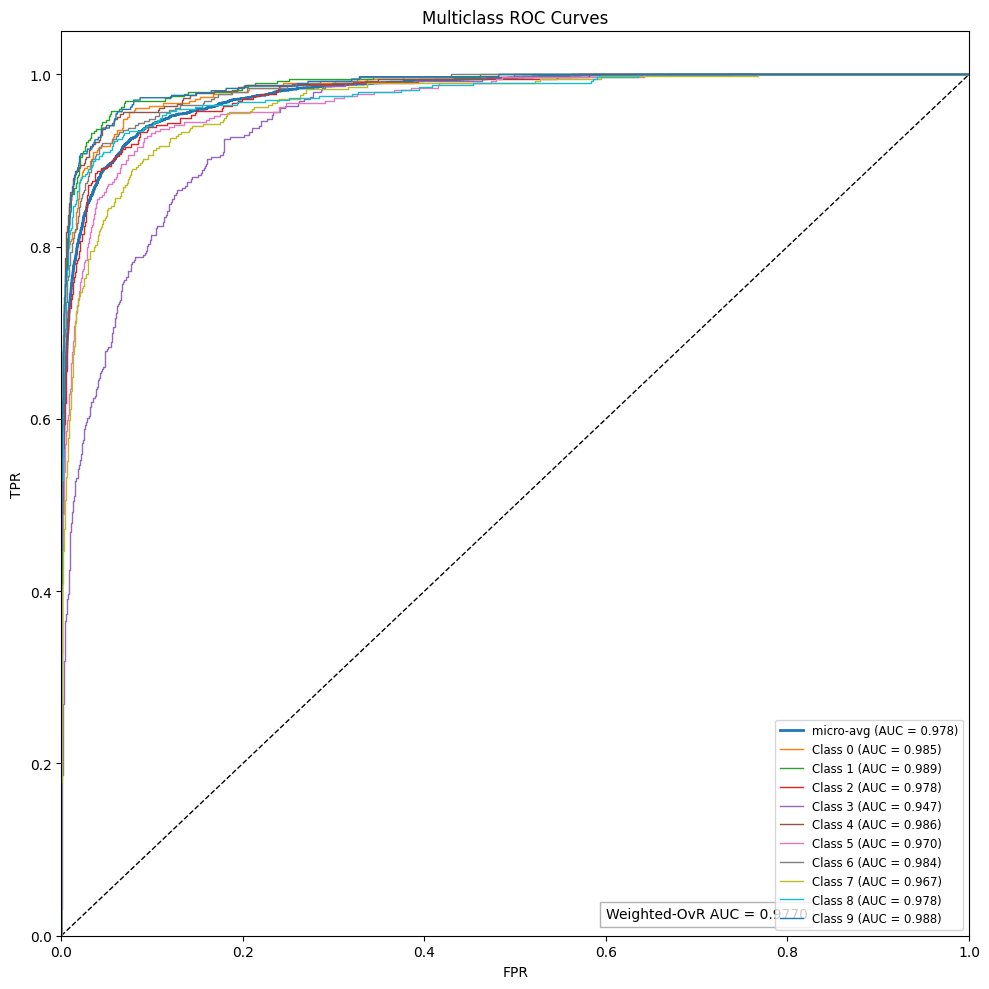

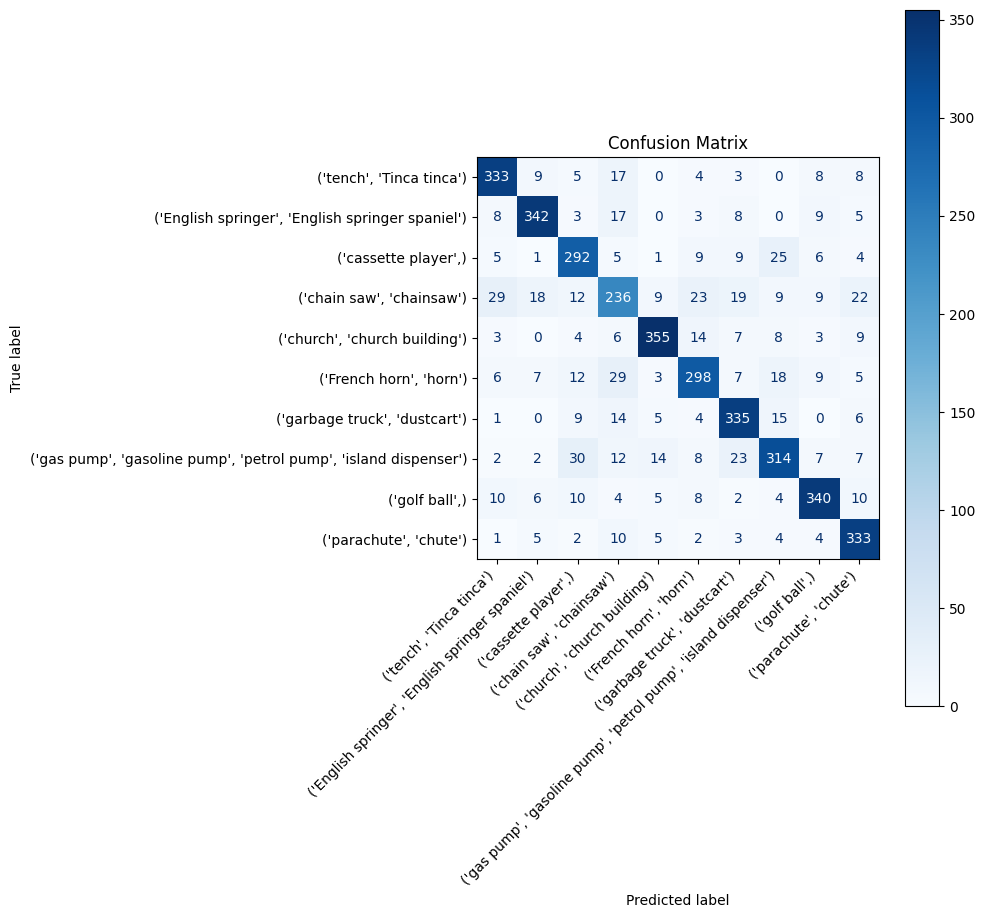

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize

# 1. Hyperparameters (tweak these as desired)
BATCH_SIZE_PER_GPU = 64
NUM_WORKERS         = 4
CHECKPOINT_PATH     = 'best_model_2.pth'

# 2. Simple validation augmentation
class DataAugmentation:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.Resize((160,160)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
    def __call__(self, img):
        return self.transform(img)

def test(batch_size, num_workers, ckpt_path):
    # 1. Load validation data
    dataset = datasets.Imagenette(
        root='/content/data',
        split='val',
        size='full',
        download=True,
        transform=DataAugmentation()
    )
    val_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
    )

    # 2. Build ResNet‑18 for 10 classes
    num_classes = len(dataset.classes)
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device).eval()

    # 3. Load checkpoint
    ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)
    model.load_state_dict(ckpt['model_state_dict'], strict=True)

    # 4. Inference
    all_labels = []
    all_preds  = []
    all_probs  = []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)
            probs  = torch.softmax(logits, dim=1)
            preds  = probs.argmax(dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # 5. Compute metrics
    acc   = accuracy_score(all_labels, all_preds)
    prec  = precision_score(all_labels, all_preds, average='weighted')
    rec   = recall_score(all_labels, all_preds, average='weighted')
    f1    = f1_score(all_labels, all_preds, average='weighted')
    w_auc = roc_auc_score(
        all_labels,
        all_probs,
        multi_class='ovr',
        average='weighted'
    )

    print(f'Accuracy:  {acc:.4f}')
    print(f'Precision: {prec:.4f}')
    print(f'Recall:    {rec:.4f}')
    print(f'F1 Score:  {f1:.4f}')
    print(f'Weighted‑OvR AUC: {w_auc:.4f}')

    # 6. Bar chart of metrics
    plt.figure(figsize=(10, 10))
    metrics = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1}
    plt.bar(metrics.keys(), metrics.values())
    plt.ylim(0, 1)
    plt.title('Validation Metrics')
    for i, (metric, value) in enumerate(metrics.items()):
        plt.text(i, value + 0.01, f'{value:.4f}', ha='center')
    plt.show()

    # 7. ROC curves
    y_true = label_binarize(all_labels, classes=range(num_classes))
    y_score = np.array(all_probs)

    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(10, 10))
    plt.plot([0,1], [0,1], 'k--', lw=1)
    plt.plot(fpr["micro"], tpr["micro"],
             label=f"micro‑avg (AUC = {roc_auc['micro']:.3f})", lw=2)
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i],
                 lw=1,
                 label=f"Class {i} (AUC = {roc_auc[i]:.3f})")
    plt.xlim(0,1)
    plt.ylim(0,1.05)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("Multiclass ROC Curves")
    plt.legend(loc="lower right", fontsize='small')
    plt.text(0.6, 0.02,
             f"Weighted‑OvR AUC = {w_auc:.4f}",
             bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray'))
    plt.tight_layout()
    plt.show()

    # 8. Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=dataset.classes)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.xticks(rotation=45, ha='right')
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()


test(BATCH_SIZE_PER_GPU, NUM_WORKERS, CHECKPOINT_PATH)